In [38]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.calibration import LabelEncoder
import matplotlib.pyplot as plt


# Load the dataset
data = pd.read_csv("updated_cleaned_recipe_dataset.csv")

# Print the dataset
print(data)


                         Recipe  \
0                     Apple Pie   
1                   Beef Burger   
2                     Beef Stew   
3                Broccoli Salad   
4                   Carrot Cake   
..                          ...   
89          Korean Bulgogi Beef   
90  Jamaican Ackee and Saltfish   
91      Lebanese Fattoush Salad   
92          Thai Massaman Curry   
93            Italian Osso Buco   

                                           Ingredient Recipe Category  \
0   ['Apple', 'Sugar', 'Flour', 'Butter', 'Cinnamon']       American    
1   ['Ground beef', 'Lettuce', 'Tomato', 'Bun', 'C...       American    
2   ['Beef', 'Potatoes', 'Carrots', 'Beef broth', ...          French   
3   ['Broccoli florets', 'Almonds', 'Dried cranber...        American   
4    ['Carrot', 'Flour', 'Sugar', 'Eggs', 'Cinnamon']        European   
..                                                ...             ...   
89  ['Beef', 'Soy sauce', 'Sesame oil', 'Garlic', ...          Korea

In [39]:
# Handle missing values if any
data.dropna(inplace=True)

In [40]:
# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

In [41]:
# Split data into features (X) and target variable (y)
# Features: All columns except for Ingredients
X = data.drop(columns=["Ingredient"])  # Features 
y = data["Ingredient"]  # Target variable

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### DEBUG ####
# Printing the shapes of training and testing data
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nTraining Data:")
print("X_train sample:")
print(X_train.head())  # assuming X_train is a DataFrame
print("\ny_train sample:")
print(y_train.head())  # assuming y_train is a Series

print("\nTesting Data:")
print("X_test sample:")
print(X_test.head())   # assuming X_test is a DataFrame
print("\ny_test sample:")
print(y_test.head())   # assuming y_test is a Series

Shape of X_train: (75, 10)
Shape of X_test: (19, 10)
Shape of y_train: (75,)
Shape of y_test: (19,)

Training Data:
X_train sample:
    Recipe  Recipe Category  Recipe Difficulty    Calories  Carbohydrates  \
65      77               28                  1  291.180000          28.58   
15      59               27                  1  358.683333          26.80   
68      30               12                  1  271.350000          29.57   
78      30               12                  1  271.350000          29.01   
30      46               14                  2  345.000000          26.00   

    Proteins  Quantity  Unit  Dietary Preference  Health Goals  
65     21.43        30    74                   2             1  
15     18.15        63    50                   3             1  
68     19.37        38    33                   2             1  
78     23.12        38    33                   2             1  
30     23.00         1     2                   3             3  

y_train sample

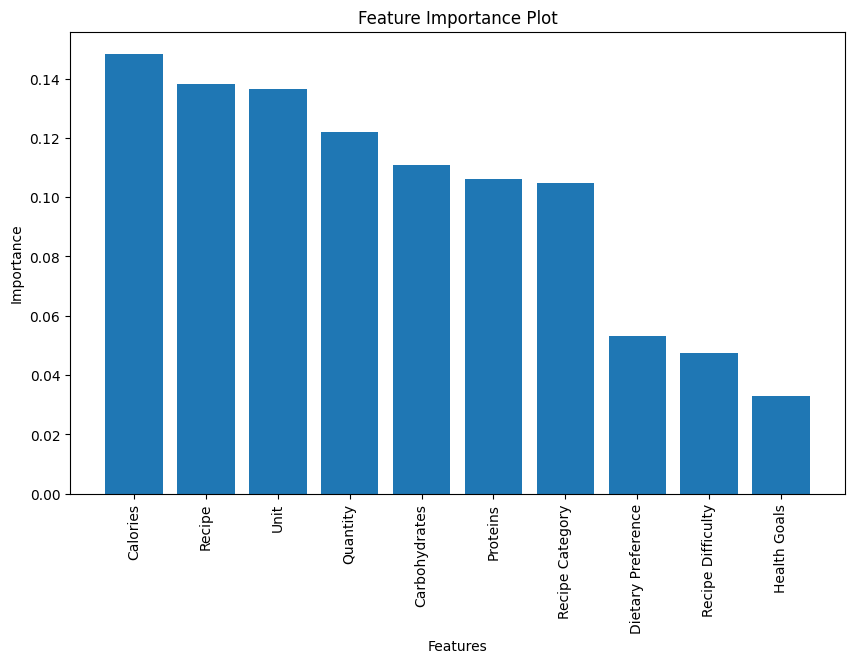

In [49]:
# Which ingredients or other features have the most significant impact on the predicted outcome (ingredient)
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

## IMPORTANCE PLOT (DID NOT PERFORM BOOTSTRAPING)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, tick_label=sorted_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.xticks(rotation=90)
plt.show()


Bootstrapped Sampling:
Randomly select samples from the dataset with replacement (bootstrapping). This creates multiple subsets of the original dataset of the same size but with some variations. Improves the model's ability to capture complex relationships between input features and target ingredients.

Feature Selection:
Randomly select a subset of features (predictors) at each node of the decision tree. This helps in promoting diversity among the trees and prevents overfitting. Helps in capturing the most relevant information from the input features while avoiding overfitting and improving the generalization performance of the model.

Decision Tree Construction:
For each bootstrap sample, grow a decision tree. At each node of the tree, choose the best split among the randomly selected subset of features.


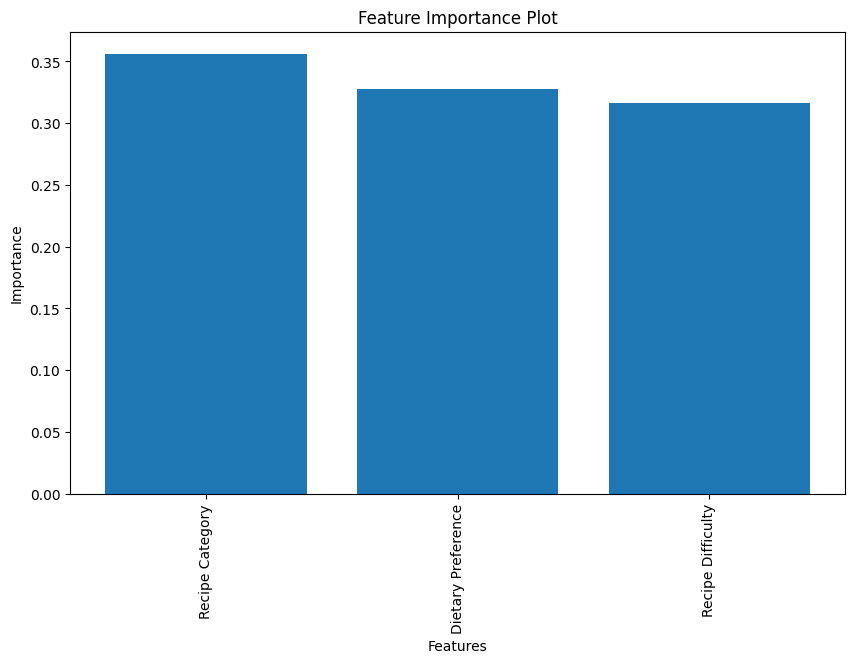

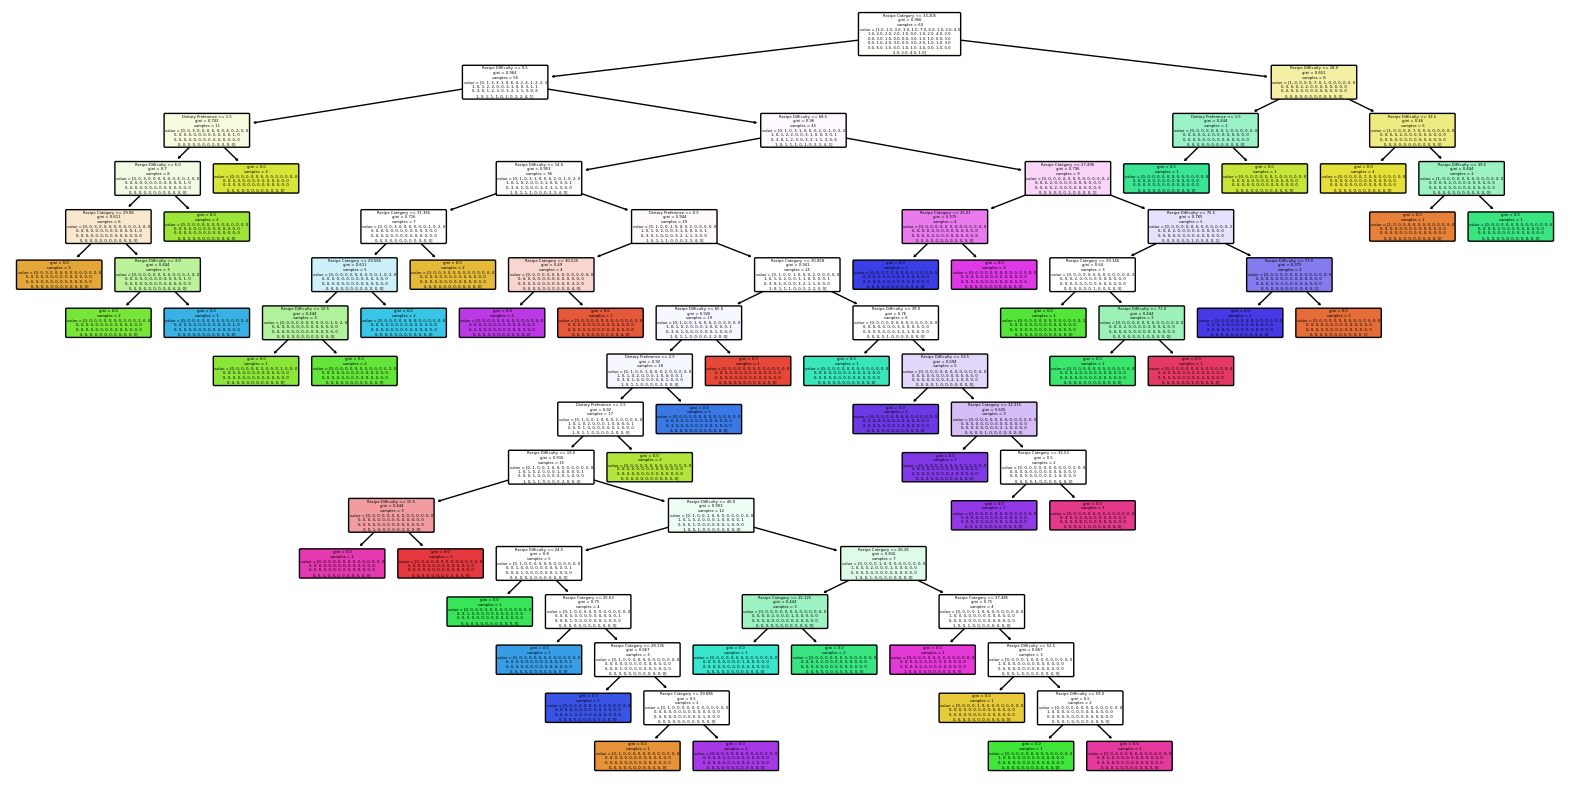

In [50]:
# Bootstrapped Sampling
import numpy as np


n_samples = data.shape[0]
bootstrap_size = n_samples
n_trees = 100  # Number of decision trees in the forest

# Initialize a list to store decision trees
forest = []

for _ in range(n_trees):
    # Randomly select samples with replacement (bootstrapping)
    bootstrap_indices = np.random.choice(range(n_samples), size=bootstrap_size, replace=True)
    bootstrap_sample = data.iloc[bootstrap_indices]

    # Features: All columns except for Ingredients
    X = bootstrap_sample.drop(columns=["Ingredient"])
    y = bootstrap_sample["Ingredient"]

    # Feature Selection
    n_features = int(np.sqrt(X.shape[1]))  # Select square root of the total number of features
    selected_features = np.random.choice(X.columns, size=n_features, replace=False)
    X = X[selected_features]

    # Decision Tree Construction
    tree = RandomForestClassifier(n_estimators=1)  # Grow a single decision tree
    tree.fit(X, y)
    forest.append(tree)

# Which ingredients or other features have the most significant impact on the predicted outcome (ingredient)
# Calculate feature importances across all trees
feature_importances = np.zeros(X.shape[1])
for tree in forest:
    feature_importances += tree.feature_importances_

# Normalize feature importances
feature_importances /= n_trees

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, tick_label=sorted_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Plot')
plt.xticks(rotation=90)
plt.show()

# Show the first decision tree in the forest
# Note: You can visualize more trees by changing the index
plt.figure(figsize=(20, 10))
plot_tree(forest[0].estimators_[0], feature_names=feature_names, filled=True, rounded=True)
plt.show()
